In [51]:
!nvidia-smi

Wed Aug 14 02:46:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.70                 Driver Version: 560.70         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   61C    P3             11W /   95W |    4526MiB /   6144MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [52]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, Xception, InceptionV3, ResNet50, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from pathlib import Path

In [53]:

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [54]:
 
# Define directory paths
train_dir = r"C:\Mushroom\notebook\Dataset\train"
test_dir = r"C:\Mushroom\notebook\Dataset\test"
img_size = (224, 224)
 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode="nearest",
    validation_split=0.2   
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Define train, validation, and test data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    class_mode="categorical",
    batch_size=100,
    subset="training"  
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    class_mode="categorical",
    batch_size=100,
    subset="validation"   
)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    class_mode="categorical",
    batch_size=100
)


Found 3746 images belonging to 7 classes.
Found 934 images belonging to 7 classes.
Found 1565 images belonging to 7 classes.


In [55]:
pretrained_models = [
    ("InceptionV3", InceptionV3(weights="imagenet", include_top=False, input_shape=(img_size[0], img_size[1], 3))),
    ("ResNet50", ResNet50(weights="imagenet", include_top=False, input_shape=(img_size[0], img_size[1], 3))),
    ("DenseNet121", DenseNet121(weights="imagenet", include_top=False, input_shape=(img_size[0], img_size[1], 3))),
    ("Xception", Xception(weights="imagenet", include_top=False, input_shape=(img_size[0], img_size[1], 3)))
]


In [56]:
models = {}
model_accuracies = {}
history_dict = {}
dir =  Path(r"C:\Mushroom\model")
for model_name, base_model in pretrained_models:
    
 
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(100, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(7, activation="softmax"))   

     
    for layer in base_model.layers:
        layer.trainable = False

 
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    
    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=5
    )

    
    print(f"Training {model_name}...")
    history = model.fit(train_data, epochs=50, validation_data=val_data, callbacks=[early_stop])

     
    loss, accuracy = model.evaluate(test_data)
    accuracy_percentage = accuracy * 100
    model_accuracies[model_name] = accuracy_percentage
    history_dict[model_name] = history.history
    print(f"{model_name} Test Accuracy: {accuracy_percentage:.2f}%\n")

   
    model_save_path = dir / f"{model_name}_Model.h5"
    model.save(model_save_path)
    print(f"Saved {model_name} model to {model_save_path}")

   
    models[model_name] = model

Training InceptionV3...
Epoch 1/50
38/38 [==============================] - 42s 1s/step - loss: 1.6060 - accuracy: 0.4840 - val_loss: 0.9979 - val_accuracy: 0.6649
Epoch 2/50
38/38 [==============================] - 41s 1s/step - loss: 0.9952 - accuracy: 0.6607 - val_loss: 0.9795 - val_accuracy: 0.6852
Epoch 3/50
38/38 [==============================] - 36s 929ms/step - loss: 0.8202 - accuracy: 0.7176 - val_loss: 0.9005 - val_accuracy: 0.7163
Epoch 4/50
38/38 [==============================] - 36s 929ms/step - loss: 0.7420 - accuracy: 0.7483 - val_loss: 0.9202 - val_accuracy: 0.7334
Epoch 5/50
38/38 [==============================] - 36s 928ms/step - loss: 0.6827 - accuracy: 0.7624 - val_loss: 0.8057 - val_accuracy: 0.7516
Epoch 6/50
38/38 [==============================] - 36s 926ms/step - loss: 0.6301 - accuracy: 0.7835 - val_loss: 0.7577 - val_accuracy: 0.7709
Epoch 7/50
38/38 [==============================] - 35s 924ms/step - loss: 0.6001 - accuracy: 0.7910 - val_loss: 0.8565 - va

In [57]:
 
print("Model Accuracies:")
for model_name, accuracy in model_accuracies.items():
    print(f"{model_name}: {accuracy:.2f}%")

Model Accuracies:
InceptionV3: 80.00%
ResNet50: 22.56%
DenseNet121: 82.36%
Xception: 82.24%


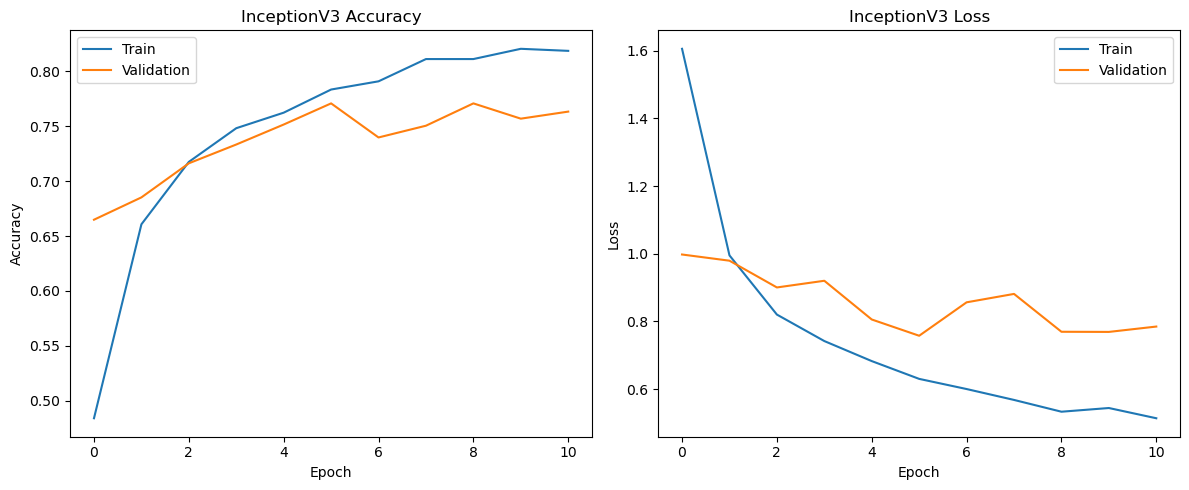

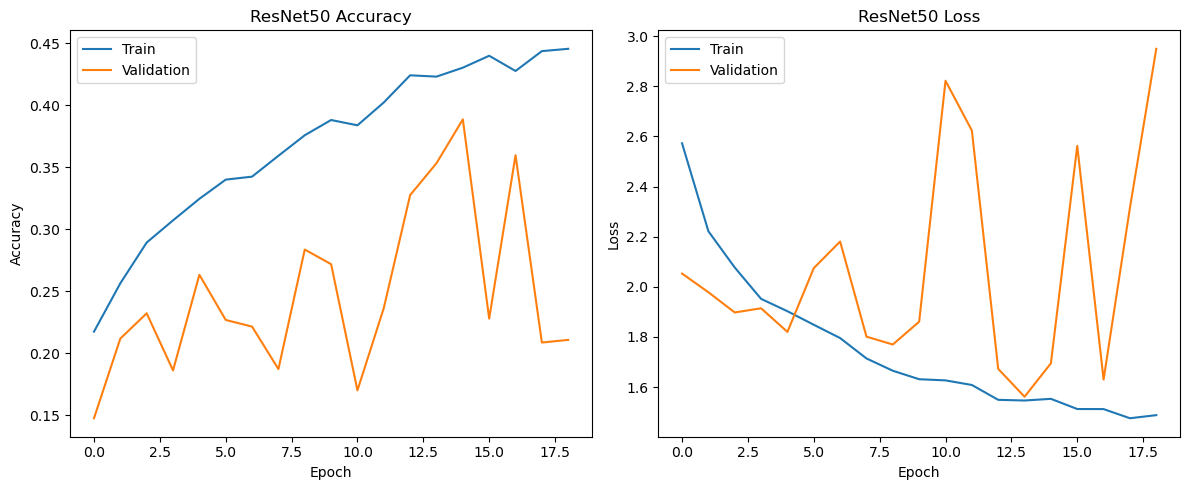

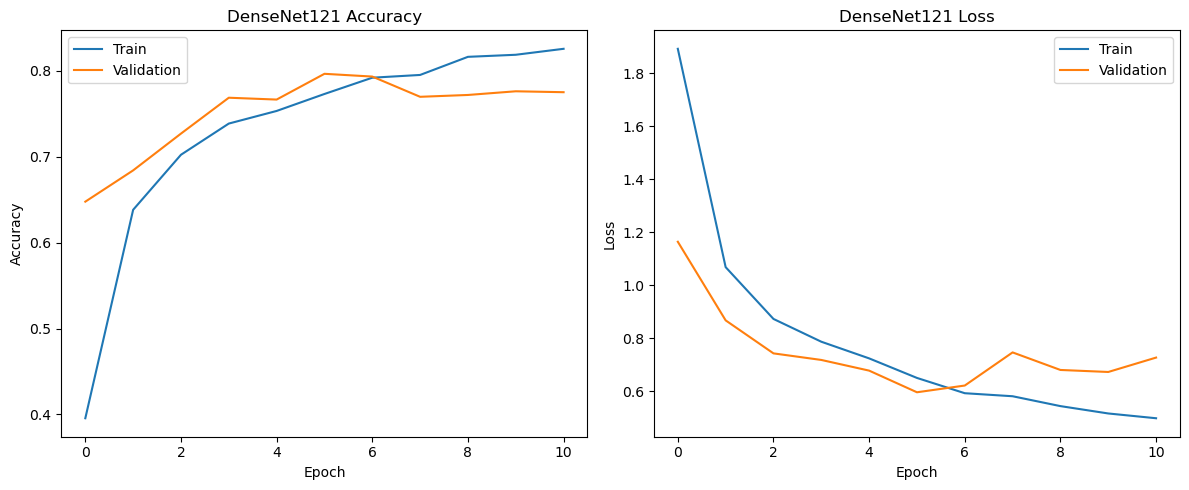

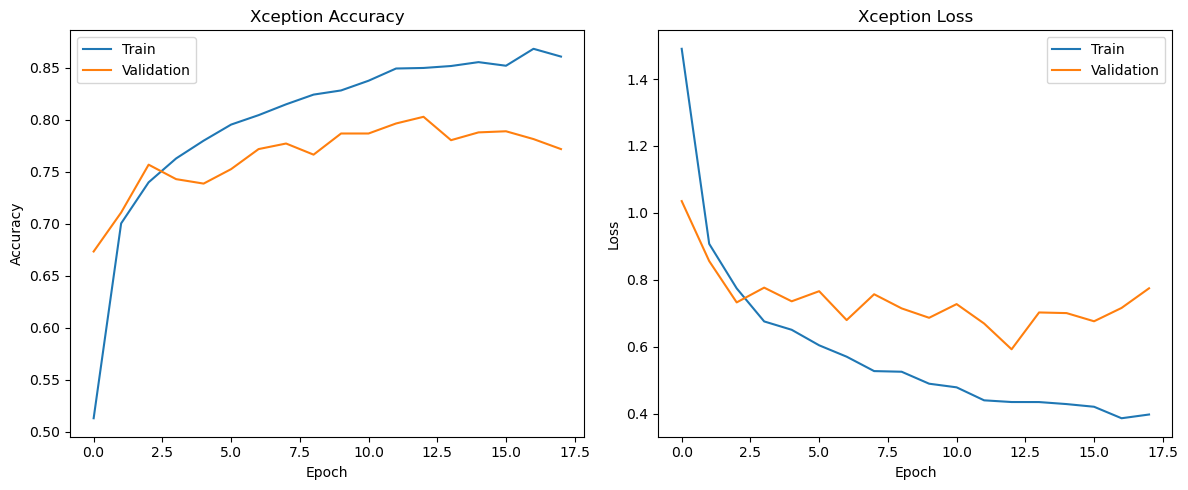

In [58]:
for model_name, hist in history_dict.items():
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(hist['accuracy'])
    plt.plot(hist['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()
 